In [1]:
from __future__ import division
from __future__ import print_function

import time
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric

from  utils import run_experiment
from models import GCN, iterativeGCN
from torch_geometric.datasets import Planetoid

In [2]:
from torch_geometric.transforms import NormalizeFeatures
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

In [3]:
model = iterativeGCN(input_dim=dataset.num_features,
                                        output_dim=dataset.num_classes,
                                        hidden_dim=16,
                                        num_train_iter=2,
                                        smooth_fac=0.7,
                                        schedule=np.full(5, 0.2),
                                        dropout=0.5)

types of schedule:
- Uniform
- Linear
- Quadratic
- Sort of like binomial theorem

In [4]:
from utils import accuracy
lr = 0.01
weight_decay = 5e-4
def run_experiment(data, lr, weight_decay, model_name, run, num_epochs=200, plot_fig=False):
    loss_TRAIN = []
    acc_TRAIN = []
    loss_VAL = []
    acc_VAL = []

    optimizer = optim.Adam(model.parameters(),
                       lr=lr, weight_decay=weight_decay)
    total_start = time.time()
    for epoch in range(num_epochs):
        t = time.time()
    
        model.train()

        output = model(data.x, data.edge_index)   
        loss_train = F.nll_loss(output[data.train_mask], data.y[data.train_mask])
        pred = output[data.train_mask].argmax(dim=1)
        acc_train = accuracy(pred, data.y[data.train_mask])
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        # print('Epoch: {:04d}'.format(epoch+1),
        #     'loss_train: {:.4f}'.format(loss_train.item()),
        #     'acc_train: {:.4f}'.format(acc_train),
        #     'loss_val: {:.4f}'.format(loss_val.item()),
        #     'acc_val: {:.4f}'.format(acc_val),
        #     'time: {:.4f}s'.format(time.time() - t))

    total_end = time.time()
    training_time = total_end - total_start
    # print("Optimization Finished!")
    # print("Total time elapsed: {:.4f}s".format(training_time))

run_experiment(data=data,
               lr=lr,
               weight_decay=weight_decay,
               model_name="lala",
               run=1)

In [5]:
model.eval()
start_time = time.time()
output = model(data.x, data.edge_index)
end_time = time.time()

loss_test = F.nll_loss(output[data.test_mask], data.y[data.test_mask])
pred = output[data.test_mask].argmax(dim=1)
acc_test = accuracy(pred, data.y[data.test_mask])
    

In [6]:
acc_test

0.392

Worked???

In [15]:
import torch.nn.functional as F
import torch
x = torch.randn((3,2))
lin = nn.Linear(2,3)
print(lin(x))
xx = F.relu(lin(x))
xxx = F.dropout(xx, p=0.5)
print("x:   ", x)
print("xx:  ", xx)
print("xxx: ", xxx)

tensor([[ 0.5932,  0.2455,  0.0502],
        [ 0.7339, -0.1077, -0.1212],
        [ 0.6121,  1.1545,  0.0539]], grad_fn=<AddmmBackward0>)
x:    tensor([[-0.3472, -1.4112],
        [-0.7772, -0.1927],
        [ 1.0629, -0.0587]])
xx:   tensor([[0.5932, 0.2455, 0.0502],
        [0.7339, 0.0000, 0.0000],
        [0.6121, 1.1545, 0.0539]], grad_fn=<ReluBackward0>)
xxx:  tensor([[0.0000, 0.0000, 0.0000],
        [1.4678, 0.0000, 0.0000],
        [0.0000, 2.3089, 0.0000]], grad_fn=<MulBackward0>)


In [18]:
m = nn.Dropout(p=0.2)
input = torch.randn(2,2)
output = m(input)
print(input)
print(output)

tensor([[-0.1662,  0.2268],
        [-0.5206, -1.1628]])
tensor([[-0.2078,  0.2835],
        [-0.6508, -1.4535]])


In [7]:
np.linspace(1, 5, 20)

array([1.        , 1.21052632, 1.42105263, 1.63157895, 1.84210526,
       2.05263158, 2.26315789, 2.47368421, 2.68421053, 2.89473684,
       3.10526316, 3.31578947, 3.52631579, 3.73684211, 3.94736842,
       4.15789474, 4.36842105, 4.57894737, 4.78947368, 5.        ])

In [13]:
import numpy as np
import torch
import torch.nn.functional as F
np.arange(0.5, 1 , 0.1) .size

5

In [34]:
torch.set_printoptions(precision=4)
F.sigmoid(torch.Tensor(np.arange(1.5, 10, 0.5)))

tensor([0.8176, 0.8808, 0.9241, 0.9526, 0.9707, 0.9820, 0.9890, 0.9933, 0.9959,
        0.9975, 0.9985, 0.9991, 0.9994, 0.9997, 0.9998, 0.9999, 0.9999])

In [5]:
a = np.arange(1.5, 10, 0.5)
print(a)
print(a[-1])

[1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5 7.  7.5 8.  8.5 9.  9.5]
9.5


{'bodies': [<matplotlib.collections.PolyCollection at 0x11dc3f2b0>,
 'cmeans': <matplotlib.collections.LineCollection at 0x11dcbe8e0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x11dc391f0>,
 'cmins': <matplotlib.collections.LineCollection at 0x11dce5160>,
 'cbars': <matplotlib.collections.LineCollection at 0x11dce54f0>,
 'cmedians': <matplotlib.collections.LineCollection at 0x11dce5880>}

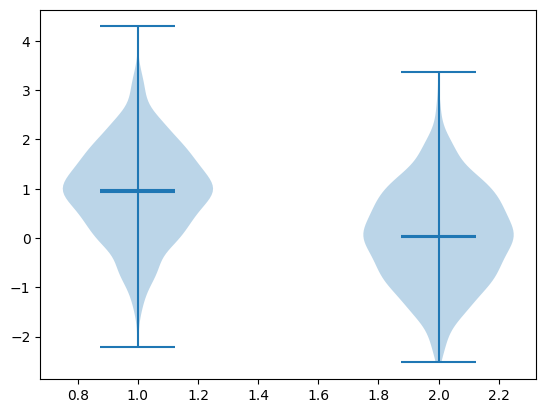

In [26]:
import bisect
import matplotlib.pyplot as plt
import numpy as np
a = np.random.normal(1, 1, 1000)
b = np.random.normal(0, 1, 1000)
plt.violinplot([a, b], showmeans=True, showmedians=True)